## CNN Train Script

Este es el archivo donde se hará una prueba de clasificador automático mediante CNN (Convolutional Neural Network).

De manera independiente se van a cargar las librerías necesarias para el script.
A la hora de realizar este script, Tensorflow/Keras no es aún compatible con Python 3.12, así que se usará la versión de Python 3.11.6

In [1]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import OneHotEncoder

Para puntualizar ahora mismo, se añadirán mas tipos en un futuro.
1. original_signals → Etiqueta 0.
2. flicker_signals → Etiqueta 1.
3. harmonic_signals → Etiqueta 2.
4. Interruption_signals → Etiqueta 3.
5. original_signals → Etiqueta 4.
6. Swell_signals → Etiqueta 5.
7. transient_signals → Etiqueta 6.

In [2]:
def preprocess_signal(signal):

    # Parámetros teóricos
    max_theoretical_value = 230 * np.sqrt(2)

    # Media de la señal
    mean_value = np.mean(signal)

    # Datos sin sesgo
    unbias_data = signal - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    # Cálculo de características
    variance = np.var(unbias_data)  # Varianza
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)  # Asimetría
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3  # Curtosis
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal)[2:4])) / np.abs(np.fft.fft(signal)[1]))  # Distorsión armónica total
    rms = np.sqrt(np.mean(signal ** 2))  # Valor RMS
    crest_factor = np.max(signal) / rms  # Factor de cresta

    # Devuelve todas las características en un vector
    return np.array([variance, skewness, kurtosis, thd, crest_factor])

def load_signal(data_path):

    # Asignar etiquetas explícitamente
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signals": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
    }

    # Inicialización de listas para características y etiquetas
    features = []
    labels = []

    # Iterar por cada tipo de perturbación
    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)

        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)

                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)

                            # Cargar la señal
                            signal = np.load(file_path)

                            # Procesar la señal y extraer características
                            feature_vector = preprocess_signal(signal)

                            # Agregar las características y etiquetas a las listas
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Ejemplo de uso
data_path = "data"  # Ajusta esta ruta según sea necesario
features, labels = load_signal(data_path)

print(f"Características extraídas: {features.shape}")
print(f"Etiquetas extraídas: {labels.shape}")


# Contar las etiquetas únicas en los datos originales 
unique_labels, counts = np.unique(labels, return_counts=True)
print("Etiquetas únicas:", unique_labels)
print("Distribución de señales por categoría:")
for label, count in zip(unique_labels, counts):
    print(f"Clase {label}: {count} señales")

# Verificar que la clase 3 está presente
if 3 not in unique_labels: 
    print("Error: La clase 3 no está presente en los datos originales.")
    

Características extraídas: (75600, 5)
Etiquetas extraídas: (75600,)
Etiquetas únicas: [0 1 2 3 4 5 6]
Distribución de señales por categoría:
Clase 0: 10800 señales
Clase 1: 10800 señales
Clase 2: 10800 señales
Clase 3: 10800 señales
Clase 4: 10800 señales
Clase 5: 10800 señales
Clase 6: 10800 señales


In [3]:
# Dividir los datos en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verificar la forma de las características y etiquetas
print(f"Características de entrenamiento: {X_train.shape}")
print(f"Características de validación: {X_val.shape}")
print(f"Características de test: {X_test.shape}")
print(f"Etiquetas de entrenamiento: {y_train.shape}")
print(f"Etiquetas de validación: {y_val.shape}")
print(f"Etiquetas de test: {y_test.shape}")

# Si las etiquetas no están en formato one-hot, convertirlas
# Esto es necesario solo si decides usar categorical_crossentropy
y_train_one_hot = to_categorical(y_train, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

# Definir el modelo
model = Sequential([
    Dense(256, activation='tanh',input_shape=(5,),kernel_regularizer=l2(0.001)),  # Capa de entrada
    Dropout(0.2),
    Dense(128, activation='tanh'),  # Capa oculta 1
    Dropout(0.2),
    Dense(64, activation='tanh'),  # Capa oculta 2 
    Dropout(0.2),
    Dense(32, activation='tanh'),  # Capa oculta 3
    Dense(7, activation='softmax')  # Capa de salida (7 clases)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Pérdida para clasificación multiclase (one-hot encoded)
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=50,
                    batch_size=32)

# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {accuracy:.2f}")

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusión:\n", conf_matrix)

# Calcular el informe de clasificación
class_report = classification_report(y_test_classes, y_pred_classes)
print("Informe de Clasificación:\n", class_report)


Características de entrenamiento: (52920, 5)
Características de validación: (11340, 5)
Características de test: (11340, 5)
Etiquetas de entrenamiento: (52920,)
Etiquetas de validación: (11340,)
Etiquetas de test: (11340,)
Epoch 1/50


/Users/saguadog/Documents/TesisSergioAguado/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-21 22:40:12.604435: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-01-21 22:40:12.604463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-01-21 22:40:12.604469: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-01-21 22:40:12.604815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-21 22:40:12.604824: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.4085 - loss: 1.5113 - val_accuracy: 0.7347 - val_loss: 0.8366
Epoch 2/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7315 - loss: 0.8337 - val_accuracy: 0.8062 - val_loss: 0.6134
Epoch 3/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7897 - loss: 0.6449 - val_accuracy: 0.8442 - val_loss: 0.5046
Epoch 4/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8193 - loss: 0.5479 - val_accuracy: 0.8653 - val_loss: 0.4518
Epoch 5/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8378 - loss: 0.4936 - val_accuracy: 0.8668 - val_loss: 0.4032
Epoch 6/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8479 - loss: 0.4523 - val_accuracy: 0.8764 - val_loss: 0.3602
Epoch 7/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8543 - loss: 0.4216 - val_accuracy: 0.8819 - val_loss: 0.3283
Epoch 8/50
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8652 - loss: 0.38

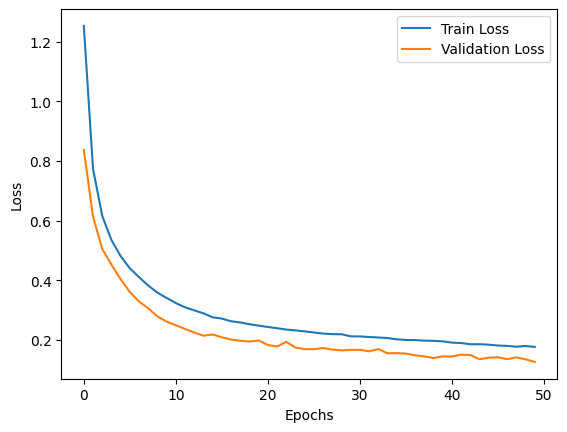

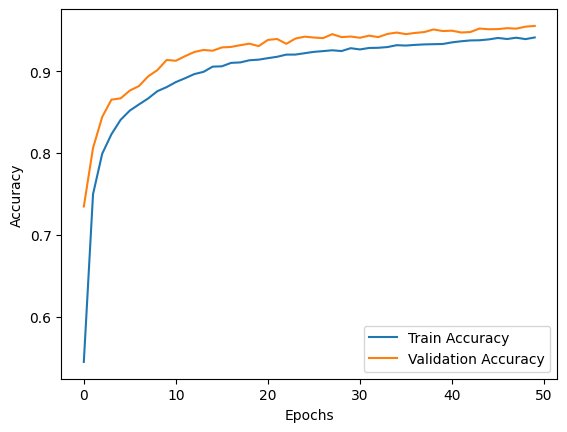

In [4]:
# Gráfico de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()